In [1]:
import scipy.io
import h5py

from scipy.stats import describe

from io import BytesIO
from io import StringIO
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.rcParams['figure.figsize'] = [15, 7.5]

In [37]:
data = h5py.File('nyu_depth_v2_labeled.mat')

In [3]:
data['depths'], data['images'], data['labels'], data['scenes']

(<HDF5 dataset "depths": shape (1449, 640, 480), type "<f4">,
 <HDF5 dataset "images": shape (1449, 3, 640, 480), type "|u1">,
 <HDF5 dataset "labels": shape (1449, 640, 480), type "<u2">,
 <HDF5 dataset "scenes": shape (1, 1449), type "|O">)

In [90]:
[''.join(chr(x) for x in data[data['names'][0][i]]) for i in range(893)]

['book',
 'bottle',
 'cabinet',
 'ceiling',
 'chair',
 'cone',
 'counter',
 'dishwasher',
 'faucet',
 'fire extinguisher',
 'floor',
 'garbage bin',
 'microwave',
 'paper towel dispenser',
 'paper',
 'pot',
 'refridgerator',
 'stove burner',
 'table',
 'unknown',
 'wall',
 'bowl',
 'magnet',
 'sink',
 'air vent',
 'box',
 'door knob',
 'door',
 'scissor',
 'tape dispenser',
 'telephone cord',
 'telephone',
 'track light',
 'cork board',
 'cup',
 'desk',
 'laptop',
 'air duct',
 'basket',
 'camera',
 'pipe',
 'shelves',
 'stacked chairs',
 'styrofoam object',
 'whiteboard',
 'computer',
 'keyboard',
 'ladder',
 'monitor',
 'stand',
 'bar',
 'motion camera',
 'projector screen',
 'speaker',
 'bag',
 'clock',
 'green screen',
 'mantel',
 'window',
 'ball',
 'hole puncher',
 'light',
 'manilla envelope',
 'picture',
 'mail shelf',
 'printer',
 'stapler',
 'fax machine',
 'folder',
 'jar',
 'magazine',
 'ruler',
 'cable modem',
 'fan',
 'file',
 'hand sanitizer',
 'paper rack',
 'vase',
 'a

Counter({0: 59792,
         5: 2959,
         11: 34710,
         21: 42715,
         28: 4657,
         64: 47710,
         84: 5578,
         85: 6572,
         88: 8675,
         89: 51097,
         98: 117,
         99: 954,
         119: 3714,
         137: 2497,
         141: 2053,
         157: 17735,
         177: 11234,
         389: 399,
         794: 3645,
         795: 387})

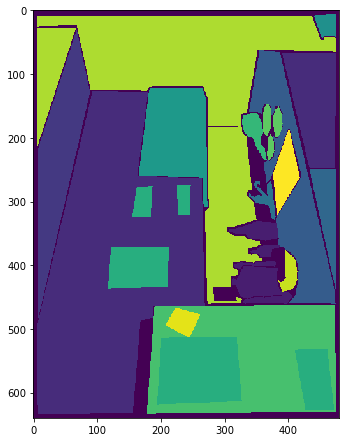

In [39]:
from collections import Counter

plt.imshow(data['labels'][1])
describe(data['labels'][1].reshape(-1))
Counter(list(data['labels'][1000].reshape(-1)))

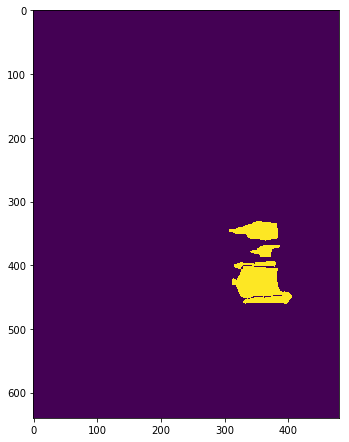

In [87]:
plt.imshow(data['labels'][1] == 2)


In [9]:
data['labels'][1].reshape(-1)

array([0, 0, 0, ..., 0, 0, 0], dtype=uint16)

Raw Size:  921600
Raw Image: 


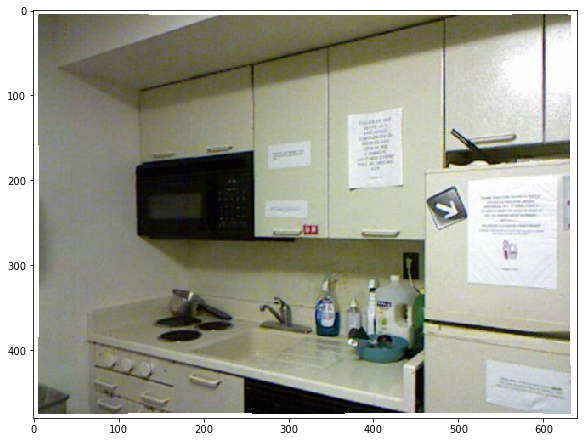

Compressed Size:  41339
Compressed Image: 


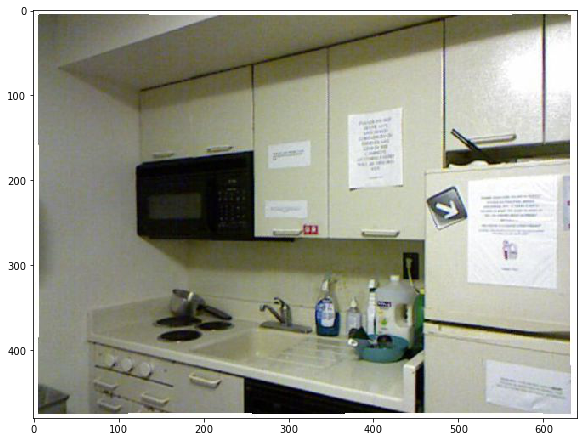

In [6]:
from io import BytesIO
from PIL import Image

# Path of the original file
input_img = data['images'][1].transpose(2, 1, 0)

image = Image.fromarray(input_img)
buffer = BytesIO()
image.save(buffer, format="JPEG", quality=80)

print("Raw Size: ", input_img.nbytes)
print("Raw Image: ")
plt.imshow(input_img)
plt.show()

print("Compressed Size: ", buffer.getbuffer().nbytes)
print("Compressed Image: ")
recon_img = Image.open(buffer)
plt.imshow(recon_img)
plt.show()

In [96]:
def imp_blur(img, labels, buffer, class_imp=np.ones(893), quality_imp=[80,20], grid_size=(16,16)):
    x, y = grid_size
    img_x, img_y, _ = img.shape
    new_img = np.zeros_like(img)
    assert(img_x % x == 0 and img_y % y == 0)
    for idx_x in range(0, int(img_x/x)):
        for idx_y in range(0, int(img_y/y)):
            sub_img = Image.fromarray(img[x*idx_x:x*idx_x+x, y*idx_y:y*idx_y+y])
            sub_lbl = labels[x*idx_x:x*idx_x+x, y*idx_y:y*idx_y+y]
            score = np.mean([class_imp[sub_lbl] for el in sub_lbl.reshape(-1)])
            
            if idx_x % 20 == 0 and idx_y % 20 == 0:
                pass # print(score)
            
            buffer = BytesIO()
            if score > 0.05:
                sub_img.save(buffer, format="JPEG", quality=50)
            else:
                sub_img.save(buffer, format="JPEG", quality=1)
                
            new_sub_img = Image.open(buffer)
            new_img[x*idx_x:x*idx_x+x, y*idx_y:y*idx_y+y] = np.array(new_sub_img.getdata()).reshape(x,y,-1)
    return new_img
            
def imp_decompress(buffer):
    pass

Raw Size:  921600
Raw Image: 


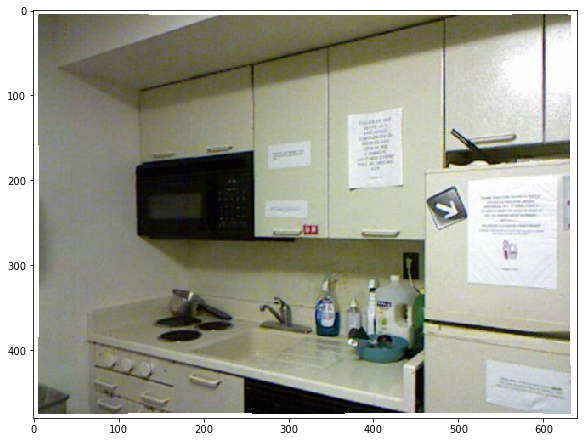

Compressed Size:  6895
Compressed Image: 


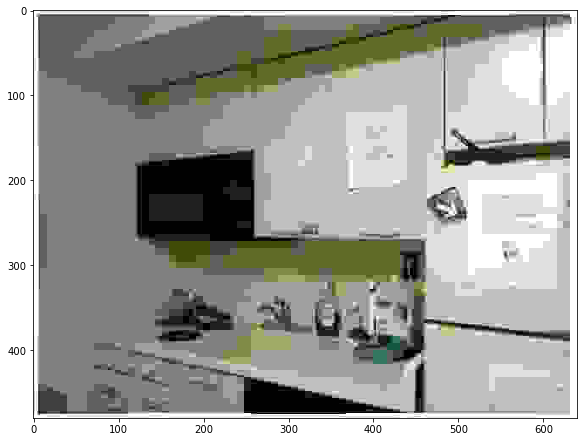

Blurred Size:  921600
Blurred Image: 


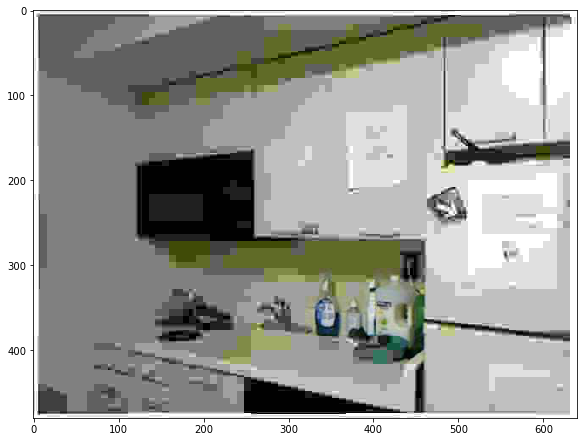

Blurred Compressed Size:  11654
Blurred Compressed Image: 


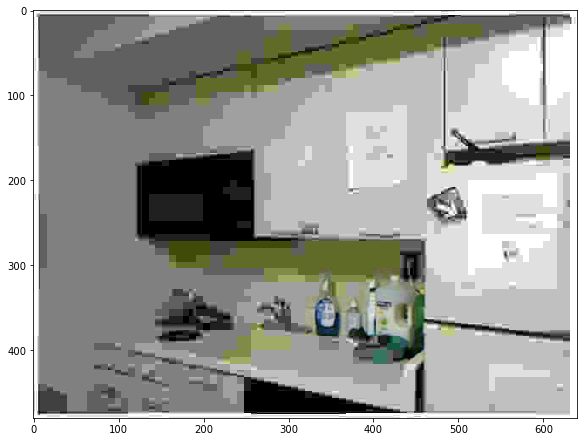

In [98]:
input_img = data['images'][1].transpose(2, 1, 0)
input_labels = data['labels'][1].transpose(1, 0)
class_imp = np.zeros(893)
class_imp[2] = 1 #bottles

img_pil = Image.fromarray(input_img)
new_img = imp_blur(input_img, input_labels, buffer, class_imp)
new_img_pil = Image.fromarray(new_img)

print("Raw Size: ", input_img.nbytes)
print("Raw Image: ")
plt.imshow(input_img)
plt.show()

buffer = BytesIO()
img_pil.save(buffer, format="JPEG", quality=1)

print("Compressed Size: ", buffer.getbuffer().nbytes)
print("Compressed Image: ")
recon_img = Image.open(buffer)
plt.imshow(recon_img)
plt.show()

print("Blurred Size: ", new_img.nbytes)
print("Blurred Image: ")
plt.imshow(new_img)
plt.show()

buffer = BytesIO()
new_img_pil.save(buffer, format="JPEG", quality=50)

print("Blurred Compressed Size: ", buffer.getbuffer().nbytes)
print("Blurred Compressed Image: ")
recon_img = Image.open(buffer)
plt.imshow(recon_img)
plt.show()

